# Hierarchical Dispatch

This notebook illustrates an example of how to use Osier's `LogicDispatchModel`.

In [1]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unyt import MW, GW, km, unyt_array, MWh

# osier imports
from osier import LogicDispatchModel, DispatchModel, Technology
from osier.tech_library import nuclear_adv, wind, battery, natural_gas
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

In [2]:
N=24
rng = np.random.default_rng(seed=1234)
demand = np.ones(N)*100
wind_speed = rng.weibull(a=2.5,size=N)

In [3]:
wind_speed

array([1.1834863 , 0.87425385, 1.26867974, 0.92048942, 0.99288288,
       0.70777819, 0.51234619, 0.66997887, 1.19183329, 0.97593545,
       1.23884103, 1.94915005, 1.4527992 , 0.62421145, 0.80997075,
       0.90325749, 1.59025684, 0.53241093, 0.29405815, 1.50525937,
       0.49367201, 1.69647415, 0.84273206, 1.02030048])

In [4]:
nuclear_adv.capacity = 50
wind.capacity = 100
battery.capacity = 10

natural_gas.capacity = 50

In [5]:
tech_list = [nuclear_adv, wind, battery, natural_gas]
tech_list

[Nuclear_Adv: 50.0 MW,
 WindTurbine: 100.0 MW,
 Battery: 10.0 MW,
 NaturalGas_Conv: 50.0 MW]

In [6]:
net_demand = demand - wind_speed*wind.capacity.to_value()
net_demand

array([-18.34863006,  12.57461479, -26.86797378,   7.9510584 ,
         0.71171164,  29.22218085,  48.76538146,  33.00211302,
       -19.1833294 ,   2.40645464, -23.88410258, -94.91500492,
       -45.27992004,  37.57885537,  19.0029247 ,   9.67425093,
       -59.02568379,  46.75890683,  70.59418506, -50.52593657,
        50.63279914, -69.6474152 ,  15.7267945 ,  -2.0300478 ])

In [35]:
model = LogicDispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand,
                           solver='highs')

In [8]:
%%timeit
model.solve()

formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 

In [9]:
model.results

,Battery,Battery_level,Battery_charge,Nuclear_Adv,NaturalGas_Conv,Curtailment,Shortfall
0,0.000000,10.000000,-10.000000,37.500000,0.000000,-45.848630,0
1,10.000000,0.000000,0.000000,25.000000,0.000000,-22.425385,0
2,0.000000,10.000000,-10.000000,12.500000,0.000000,-29.367974,0
3,7.951058,2.048942,0.000000,0.000000,0.000000,0.000000,0
4,0.711712,1.337230,0.000000,0.000000,0.000000,0.000000,0
5,1.337230,0.000000,0.000000,12.500000,15.384951,0.000000,0
6,0.000000,0.000000,0.000000,25.000000,23.765381,0.000000,0
7,0.000000,0.000000,0.000000,33.002113,0.000000,0.000000,0
8,0.000000,10.000000,-10.000000,20.502113,0.000000,-29.685442,0
9,2.406455,7.593545,0.000000,8.002113,0.000000,-8.002113,0


In [10]:
model.solve()

formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW


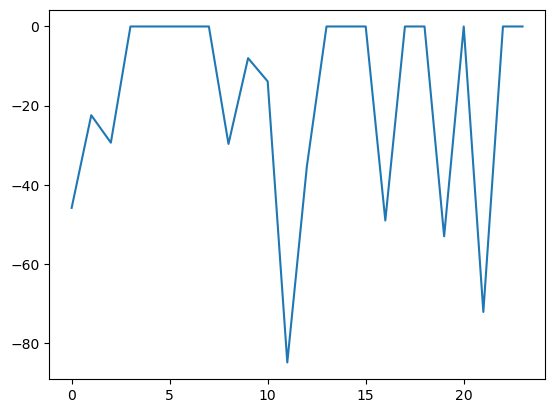

In [11]:
plt.plot(model.covered_demand)

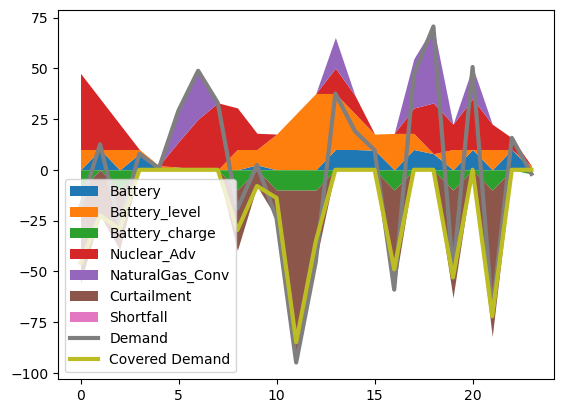

In [12]:
ax = model.results.plot.area(linewidth=0)
ax.plot(model.net_demand, lw=3, label='Demand')
ax.plot(model.covered_demand, lw=3, label='Covered Demand')
ax.legend()

In [13]:
original_model = DispatchModel(technology_list=[t for t in tech_list if t.dispatchable],
                           net_demand=net_demand)

In [14]:
%%timeit
original_model.solve()

75.1 ms ± 648 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
model.solve()

formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 

In [16]:
model._reset_all()

In [17]:
len(model.technology_list[0].power_history)

0

In [18]:
original_model.solve()

In [19]:
og_res = original_model.results.copy()

In [20]:
og_res.round(10)

,Nuclear_Adv,Battery,NaturalGas_Conv,Curtailment,Battery_charge,Battery_level,Cost
0,0.000000,0.0,0.000000,-18.348630,-0.0,0.0,0.0
1,12.500000,0.0,0.074615,-0.000000,-0.0,0.0,0.000116
2,0.000000,0.0,0.000000,-26.867974,-0.0,0.0,0.0
3,7.951058,0.0,0.000000,-0.000000,-0.0,0.0,0.000073
4,16.722181,0.0,0.000000,-16.010469,-0.0,0.0,0.000153
5,29.222181,0.0,0.000000,-0.000000,-0.0,0.0,0.000268
6,41.722181,0.0,7.043201,-0.000000,-0.0,0.0,0.00054
7,29.222181,0.0,3.779932,-0.000000,-0.0,0.0,0.000352
8,16.722181,0.0,0.000000,-35.905510,-0.0,0.0,0.000153
9,4.222181,0.0,0.000000,-1.815726,-0.0,0.0,0.000039


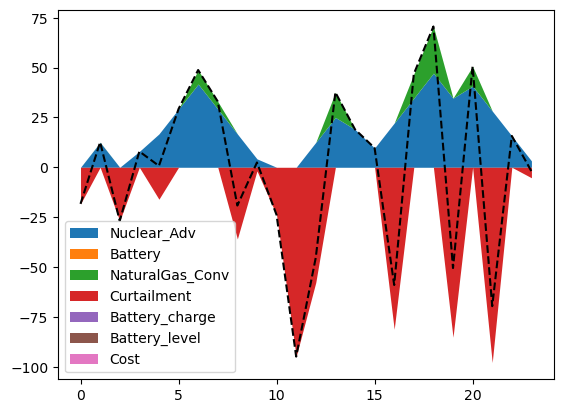

In [21]:
ax = (original_model.results.round(10)).plot.area(lw=0)
ax.plot(original_model.net_demand, color='k', linestyle='--')

In [22]:
from timeit import timeit, repeat

In [23]:
logic_time = timeit(stmt="model.solve()",
                    globals=globals(),
                    number=7)

formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW


In [24]:
logic_time = repeat(stmt="model.solve()",
                    globals=globals(),
                    repeat=7,
                    number=10)

formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 50.0 MW
formatting results for NaturalGas_Conv: 50.0 MW
formatting results for Battery: 10.0 MW
formatting results for Nuclear_Adv: 

In [25]:
(np.array(logic_time)/10*1e3).std()

np.float64(0.41863088091230266)

In [26]:
N_HOURS = 24
N_DAYS = 2
N = N_HOURS * N_DAYS

In [27]:
def technology_set_1():
    """
    This fixture creates technologies directly from
    the :class:`Technology` class.
    """
    nuclear = Technology(technology_name='Nuclear',
                         technology_type='production',
                         capacity=5,
                         capital_cost=6,
                         om_cost_variable=20,
                         om_cost_fixed=50,
                         fuel_cost=5
                         )
    natural_gas = Technology(technology_name='NaturalGas',
                             technology_type='production',
                             capacity=5,
                             capital_cost=1,
                             om_cost_variable=12,
                             om_cost_fixed=30,
                             fuel_cost=20
                             )

    return [nuclear, natural_gas]

In [28]:
def net_demand_func():
    phase_shift = 0
    base_load = 1.5
    hours = np.linspace(0, N, N)
    demand = (np.sin((hours * np.pi / N_HOURS * 2 + phase_shift))
              * -1 + np.ones(N) * (base_load + 1))

    return demand

In [29]:
m2 = LogicDispatchModel(technology_list=technology_set_1(),
                       net_demand=net_demand_func())

In [30]:
m2.solve()

formatting results for Nuclear: 5.0 MW
formatting results for NaturalGas: 5.0 MW


In [31]:
m2.technology_list

[Nuclear: 5.0 MW, NaturalGas: 5.0 MW]

In [32]:
m2.results

,Nuclear,NaturalGas,Curtailment,Shortfall
0,2.500000,0,0.0,0
1,2.235805,0,0.0,0
2,1.990383,0,0.0,0
3,1.781176,0,0.0,0
4,1.623050,0,0.0,0
5,1.527241,0,0.0,0
6,1.500558,0,0.0,0
7,1.544898,0,0.0,0
8,1.657108,0,0.0,0
9,1.829215,0,0.0,0


In [33]:
m2.covered_demand

unyt_array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 'MW')

In [34]:
m2.objective

np.float64(3000.0)